In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [5]:
# Problem 2.1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    w,w0=Initialw(X,y)
    n = X.shape[0]
    m = X.shape[1]
    stop=False
    t=0
    F=np.zeros(max_iter)
    while not stop and t<max_iter:
        w_last=w.copy()
        #print(t)
        for j in range(m):
            F[t]=0.5*np.sum((X.dot(w)+w0-y)**2)+lmda*np.sum(abs(w))
            X_nonj = np.delete(X, j, 1)  # delete k_th column
            w_nonj = np.delete(w,j) # delete k_th variable
            w_j = w[j]*np.ones((n,1))
            r_j = X_nonj.dot(w_nonj)+w0-y
            c_j = np.sum(np.multiply(X[:,j],r_j))
            a_j = np.sum(X[:,j]**2)
            if c_j > lmda:
                w[j] = (-c_j+lmda)/a_j
            elif c_j < (-lmda):
                w[j] = (-c_j-lmda)/a_j
            else:
                w[j] = 0  
        if max(abs(w-w_last))<=epsilon:
            F[t+1]=0.5*np.sum((X.dot(w)+w0-y)**2)+lmda*np.sum(abs(w))
            stop=True
        t+=1    
    return (w,w0,t,F)

In [6]:
# Problem 2.1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

[ 9.72715485 -9.43087631 -9.8792362   9.31523388  9.59724623  0.
  0.          0.49945777  0.          0.          0.          0.
  0.03223816  0.          0.27156744  0.          0.46645741  0.
  0.          0.          0.          0.          0.07998019  0.
  0.          0.          0.          0.          0.          0.34352165
  0.          0.          0.          0.          0.          0.
 -0.01068022  0.         -0.07491293  0.          0.          0.
  0.          0.04839839  0.          0.          0.          0.
  0.06165951  0.          0.          0.          0.41139583  0.
  0.          0.          0.          0.08069806 -0.24522583  0.
  0.         -0.22815069  0.08098431  0.          0.0940461   0.
 -0.05337294  0.          0.14101791 -0.31762519  0.          0.
  0.17515956  0.01444683  0.        ]


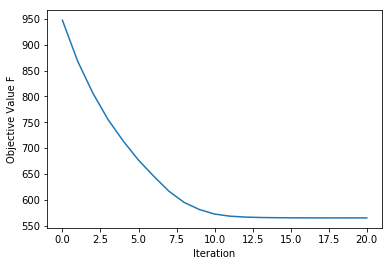

In [8]:
# Problem 2.1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso,t,F= lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
## plot F(t)
F=F[:t]
t = np.linspace(0,t-1,t)
plt.plot(t,F)
plt.xlabel('Iteration')
plt.ylabel('Objective Value F')
plt.show()

In [11]:
def NonZero(w):
    num=0
    for i in range(len(w)):
        if w[i]!=0:
            num+=1
    return num

In [12]:
def NonZero2(w,w_true):
    num=0
    for i in range(len(w)):
        if w[i]!=0 and w_true[i]!=0:
            num+=1
    return num

In [7]:
def root_mean_square_error(pred, y):
    rmse = np.sqrt(np.sum((y-pred)**2)/np.size(y))
    return rmse

In [14]:
# Problem 2.2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    nz_w = NonZero(w)
    nz_wtrue = NonZero(w_true)
    nz = NonZero2(w,w_true)
    if nz_w==0:
        nz_w=1
    precision_w = nz/nz_w
    recall_w = nz/nz_wtrue
    sparsity_w = nz_w
    rmse=root_mean_square_error(np.dot(X,w)+w0,y)
    return (rmse, sparsity_w, precision_w, recall_w)

In [15]:
# Problem 2.2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print('RMSE:\n',Emetric[0],'\n')
print('sparsity:\n',Emetric[1],'\n')
print('precision:\n',Emetric[2],'\n')
print('recall:\n',Emetric[3],'\n')

RMSE:
 1.3868108567738688 

sparsity:
 26 

precision:
 0.19230769230769232 

recall:
 1.0 



In [16]:
# Problem 2.3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y,num=50):
    n = X.shape[0]
    m = X.shape[1]
    W = np.zeros((50,m))
    W0 = np.zeros((50,1))
    t = np.zeros((50,1))
    F = np.zeros((50,100))
    y_means = np.mean(y)
    lmda_max = np.max(np.dot((y-y_means),X))
    lmda_min = 0.05*lmda_max
    Lmda = np.linspace(lmda_min,lmda_max,num)
    for i in range(num):
        W[i,:], W0[i],t[i],F[i,:]= lasso(X, y, lmda = Lmda[i], epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
    return (W, W0, Lmda)

In [17]:
# Problem 2.3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, lmda):
    n = X.shape[0]
    m = X.shape[1]
    RMSE = np.zeros((50,1))
    Sparsity = np.zeros((50,1))
    Precision = np.zeros((50,1))
    Recall = np.zeros((50,1))
    for i in range(50):
        RMSE[i],Sparsity[i],Precision[i],Recall[i]=Evaluate(X, y, W[i,:], W0[i], w_true, w0_true)
    return (RMSE, Sparsity, Precision, Recall)

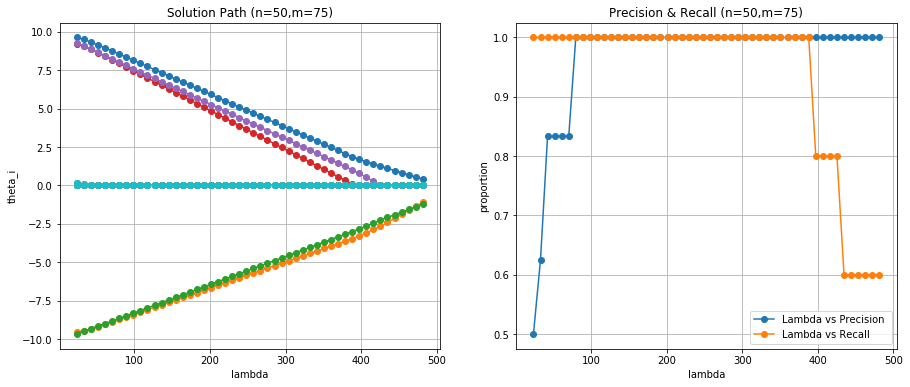

In [18]:
# Problem 2.3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
def DrawPath(X,y,w_true,w0_true):
    n = X.shape[0]
    m = X.shape[1]
    W, W0, Lmda = LassoPath(X,y)
    RMSE, Sparsity, Precision, Recall = EvaluatePath(X,y,W,W0,w_true,w0_true,Lmda)
    fig, axs = plt.subplots(1,2,figsize=(15, 6))
    theta = np.zeros(50)    
    for i in range(50):
        theta = W[:,i]
        axs[0].plot(Lmda,theta,ls = '-', marker = 'o',)
        i+=1
    axs[0].grid()
    axs[0].set_xlabel('lambda')
    axs[0].set_ylabel('theta_i')
    axs[0].set_title('Solution Path (n=%i,m=%i)' % (n, m))

    # precision & recall
    axs[1].plot(Lmda,Precision,ls = '-', marker = 'o',label = 'Lambda vs Precision ')
    axs[1].plot(Lmda,Recall,ls = '-', marker = 'o',label='Lambda vs Recall')
    axs[1].grid()
    axs[1].legend()
    axs[1].set_xlabel('lambda')
    axs[1].set_ylabel('proportion')
    axs[1].set_title('Precision & Recall (n=%i,m=%i)' % (n, m))
    
    plt.show()

DrawPath(X,y,w_true,w0_true)

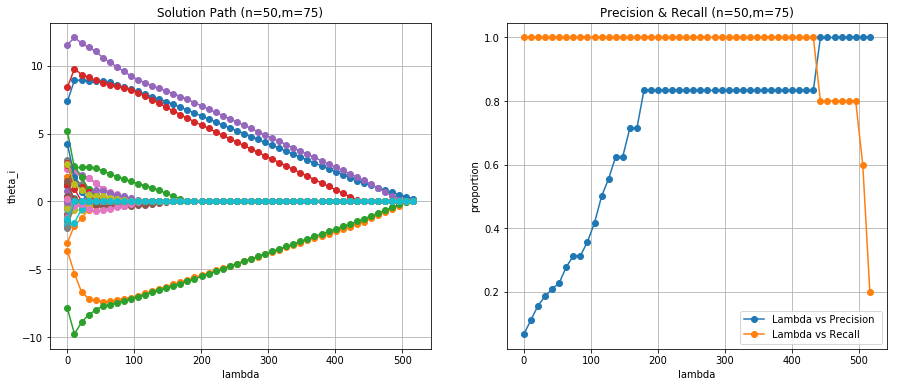

In [16]:
# Problem 2.3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
DrawPath(X,y,w_true,w0_true)

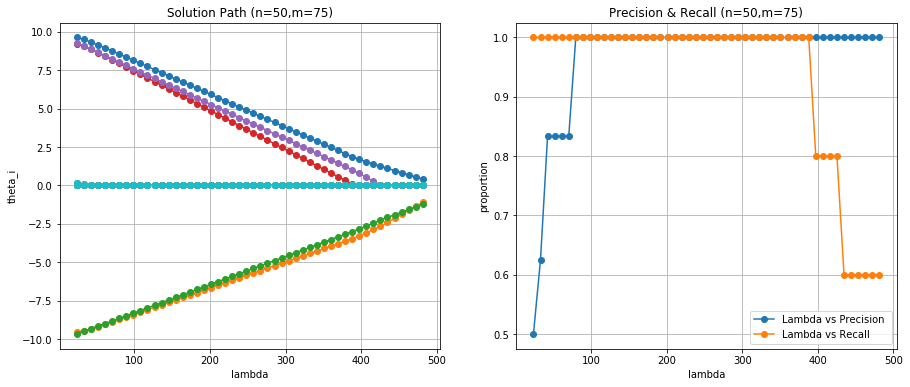

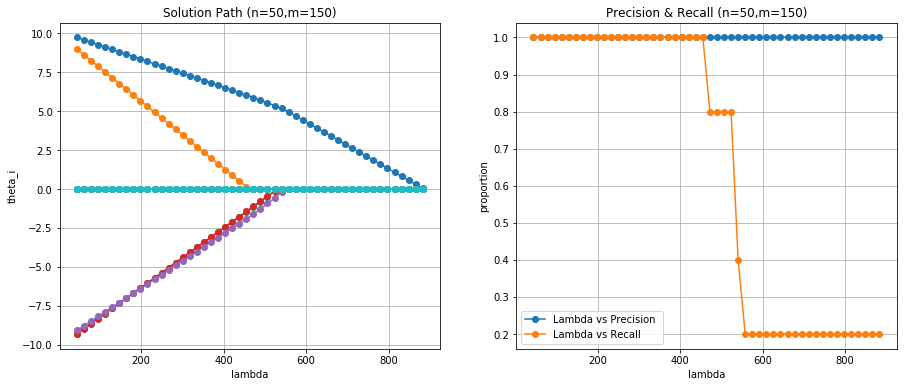

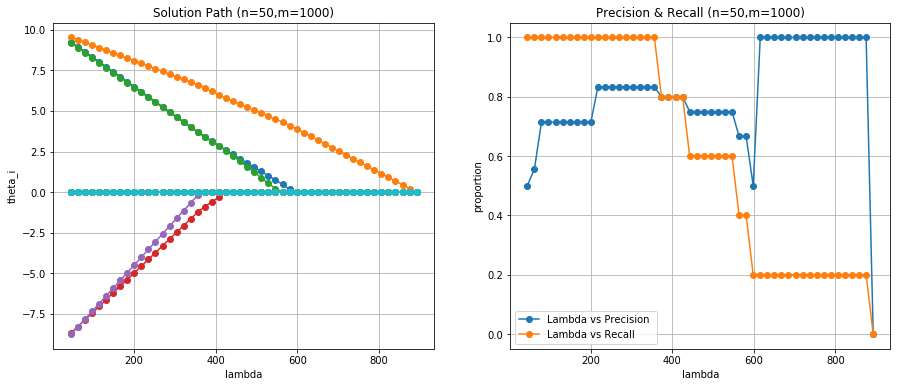

C:\Users\luyey\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


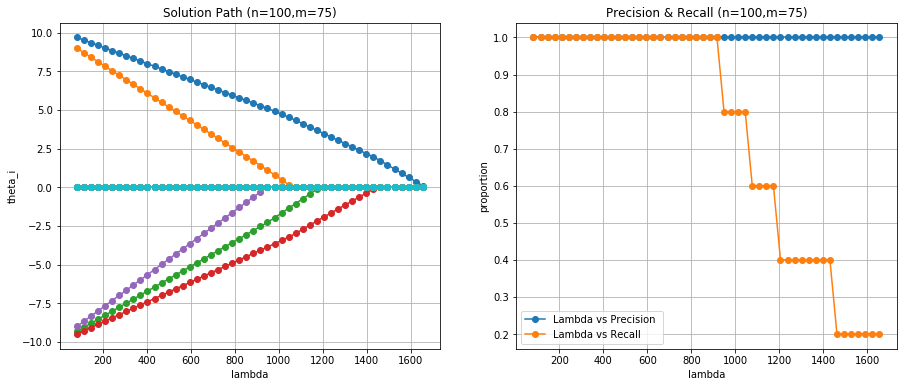

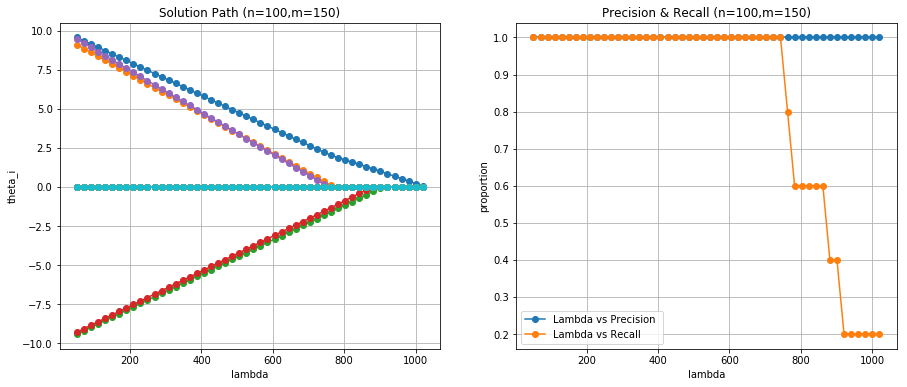

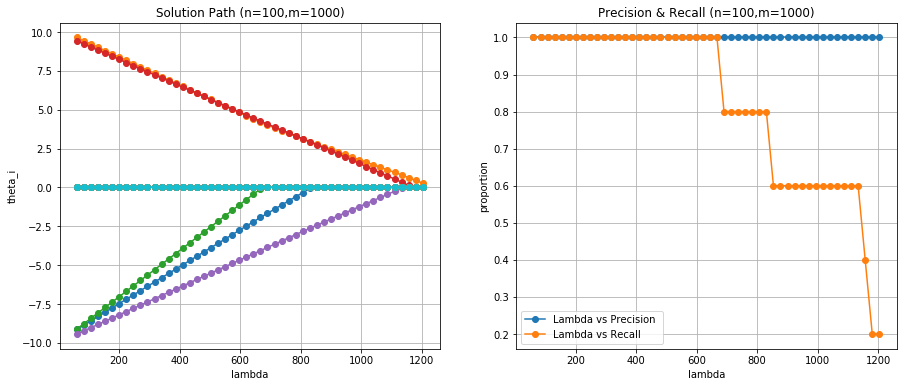

In [16]:
# Problem 2.4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)
X, y, w_true, w0_true = DataGenerator(n=50, d=1000, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)
X, y, w_true, w0_true = DataGenerator(n=100, d=75, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)
X, y, w_true, w0_true = DataGenerator(n=100, d=150, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)
X, y, w_true, w0_true = DataGenerator(n=100, d=1000, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)


C:\Users\luyey\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


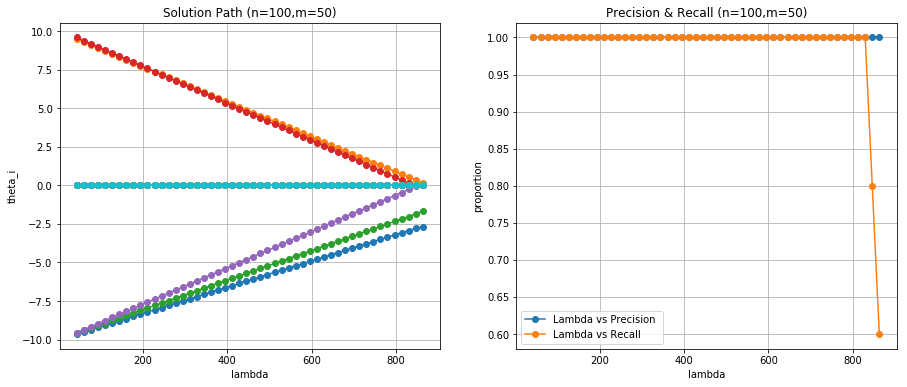

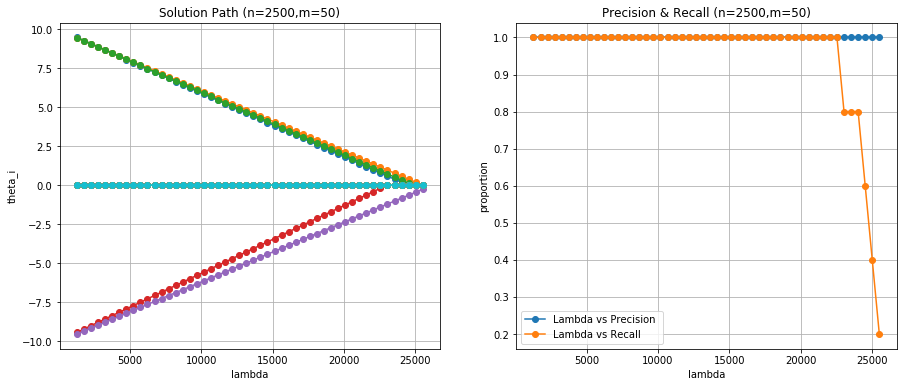

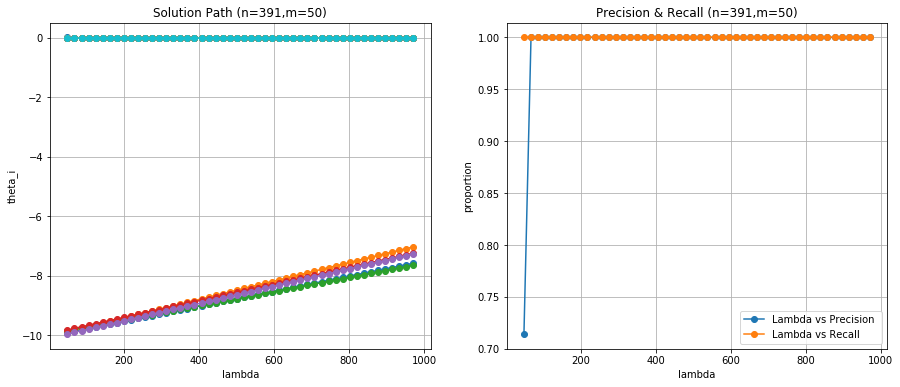

In [17]:
import math
X, y, w_true, w0_true = DataGenerator(n=100, d=50, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)
X, y, w_true, w0_true = DataGenerator(n=50**2, d=50, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)
X, y, w_true, w0_true = DataGenerator(n=int(math.log(50)*100), d=50, k=5, sigma=1.0)
DrawPath(X, y, w_true, w0_true)

In [4]:
def lasso_sparse(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    
    w,w0=Initialw(X,y)
    n = X.shape[0]
    m = X.shape[1]
    stop=False
    t=0
    diff_w=1
    F=np.zeros(max_iter)
    while diff_w>epsilon and t<max_iter:
        w_last=w.copy()
        print(t)
        for j in range(m):
            #F[t]=0.5*np.sum((csrMatDot(X,w)+w0-y)**2)+lmda*np.sum(abs(w))  
            X_nonj = delete_cols_csr(X, j)  # delete k_th column
            w_nonj = np.delete(w,j) # delete k_th variable
            
            r_j = X_nonj.dot(w_nonj)+w0-y
            c_j = np.sum(csrVecMul(X[:,j],r_j))
            a_j = np.sum(csrVecMul(X[:,j],X[:,j].toarray()))
            
            if c_j > lmda:
                w[j] = (-c_j+lmda)/a_j
            elif c_j < (-lmda):
                w[j] = (-c_j-lmda)/a_j
            else:
                w[j] = 0  
        diff_w = max(abs(w-w_last))
#             F[t+1]=0.5*np.sum((csrMatDot(X,w)+w0-y)**2)+lmda*np.sum(abs(w))
#             stop=True
        t+=1    
    return (w,w0,t,F)

In [5]:
def LassoPath_Sparse(X, y,num=50):
    n = X.shape[0]
    m = X.shape[1]
    W = np.zeros((num,m))
    W0 = np.zeros((num,1))
    t = np.zeros((num,1))
    F = np.zeros((num,100))
    #y_means = np.mean(y)
    #y_reshape = np.reshape(y-y_means,(3000,1))
    #X_reshape = np.reshape(X,(2500,3000))
    #lmda_max = np.max(X_reshape.dot(y_reshape)) 
    lmda_max = 30
    lmda_min = 0.3
    Lmda = np.linspace(lmda_min,lmda_max,num)
    y=np.reshape(y,(n,1))
    for i in range(num):
        W[i,:], W0[i],t[i],F[i,:]= lasso_sparse(X, y, lmda = Lmda[i], epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
    return (W, W0, Lmda)

In [6]:
# Problem 2.5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsr()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [7]:
def SparseRMSE(X_valid,y_valid,w_lasso,w0_lasso):
   
    RMSE = root_mean_square_error(X_valid.dot(w_lasso)+w0_lasso,y_valid)
    
    return RMSE

In [8]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    Lmda,RMSE,W,W0 = SparseRMSE(X_train, y_train,X_valid,y_valid)  
    w = np.zeros(W.shape[1])
    w0 = 0
    lmda = 0
    min_value = RMSE[0]
    for i in range(1,20):
        if RMSE[i]<min_value:
            min_value=RMSE[i]
            lmda=Lmda[i]
            w=W[i,:]
            w0=W0[i]
    return (w, w0,lmda)

In [9]:
# 2 vector multiply
def csrVecMul(x, r):
    indptr = x.indptr
    last_idx = indptr[0]
    for row_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            x.data[last_idx] *= r[row_id]
            last_idx = idx
    return x

In [10]:
# matrix and vector dot
def csrMatDot(W, x):
    dot_result=np.zeros((W.shape[0],1))
    indptr = W.indptr # number of nonzero elements in each row
    indices = W.indices # index of nonzero column
    last_idx = indptr[0]
    for row_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            dot_result[row_id] = W.data[last_idx:idx].dot(x[indices[last_idx:idx]])
            last_idx = idx
    return dot_result

In [11]:
def delete_cols_csr(mat, indices):
    mask = np.ones(mat.shape[1], dtype=bool)
    mask[indices] = False
    return mat[:,mask]

In [12]:
def lmda(y,X):
    y_m = np.mean(y)
    y_n = sparse.csc_matrix(y-y_m)
    lmda_max = np.max (y_n.dot(X))
    return lmda_max

In [ ]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('star_data.mtx', 'star_labels.txt', 'star_features.txt', 30000, 5000)
# evaluation
lmda_max = lmda(y_train,X_train)
print(lmda_max)
lmda = np.linspace(11, int(lmda_max-1),20)
rmse = np.zeros(20)
for i in range(20):
    print(lmda[i])
    w_lasso, w0_lasso, k = lasso_sparse(X_train,  y_train, lmda[i])
    rmse[i] = SparseRMSE(X_valid,y_valid,w_lasso,w0_lasso) 
print(rmse)
#print('best lambda = ' ,t[9])
# w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# # # print the top-10 features you found by lasso
# # idx = (-np.abs(w_lasso)).argsort()[0:10]
# # print('Lasso select features:')
# # for i in range(10):
# #     print(fName[idx[i]],w_lasso[idx[i]])

31.699932766687038
11.0
0
1


In [ ]:
w,w0,t,F= lasso_sparse(X_train,y_train,3)

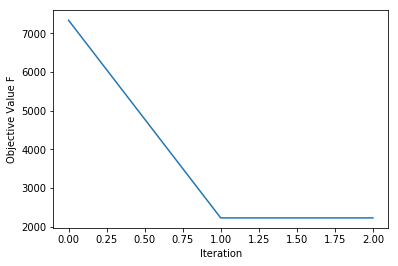

In [23]:
# lambda = 10
F=F[:t]
t = np.linspace(0,t-1,t)
plt.plot(t,F)
plt.xlabel('Iteration')
plt.ylabel('Objective Value F')
plt.show()

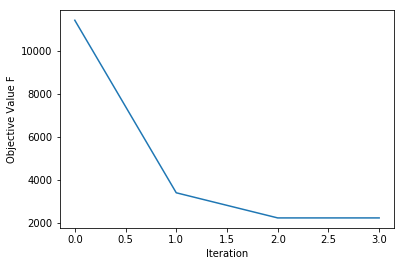

In [16]:
# lambda = 5
F=F[:t]
t = np.linspace(0,t-1,t)
plt.plot(t,F)
plt.xlabel('Iteration')
plt.ylabel('Objective Value F')
plt.show()